In [28]:
# Try pre-trained resnet
# Try full dataset ignoring nans
# More augmentations
# Learning rate finder
# Plot learning rate 
# Add notebook to tracker

# Installs 

# !pip install mlflow==1.30.1 dagshub==0.2.12 progressbar2==4.2.0 GPUtil==1.4.0 albumentations==1.3.0

# Imports

import albumentations as A
import cv2
from dataclasses import dataclass, asdict
import dagshub
from GPUtil import showUtilization as gpu_usage
import matplotlib.pyplot as plt
import mlflow
from numba import cuda
import numpy as np
import pandas as pd
from PIL import Image
import progressbar
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
from torchvision import models, transforms, utils
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch import flatten
from torchmetrics import MeanSquaredError

# General utilities 

def set_seeds():
    torch.manual_seed(0)
    np.random.seed(0)
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic=True
    
def free_gpu_cache():
    print("Initial GPU usage")
    gpu_usage()                             

    torch.cuda.empty_cache()
    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU usage after emptying the cache")
    gpu_usage()

In [31]:
# Set up

set_seeds()

DIR_PATH = "/kaggle/input/facial-keypoints-detection/"
training_data = pd.read_csv(f"{DIR_PATH}training.zip")
test_data = pd.read_csv(f"{DIR_PATH}test.zip")
id_lookup_table = pd.read_csv(f"{DIR_PATH}IdLookupTable.csv")

@dataclass  
class ModelParams:
    BATCH_SIZE: int = 64
    VALID_SIZE: float = 0.1
    N_EPOCHS: int = 100
    IMG_SIZE: int = 96
    OUTPUT_SIZE: int = 30 
    S_OUTPUT_SIZE: int = 8
    L_OUTPUT_SIZE: int = 22
    LEARNING_RATE: float = 0.001

dagshub.init("facial_reg_model", "caddis90", mlflow=True)
mlflow.set_tracking_uri('https://dagshub.com/caddis90/facial_reg_model.mlflow')
mlflow.set_experiment(experiment_name="cnn")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

l_dataset_cols = [
    'left_eye_inner_corner_x','left_eye_inner_corner_y', 'left_eye_outer_corner_x',
    'left_eye_outer_corner_y', 'right_eye_inner_corner_x','right_eye_inner_corner_y',
    'right_eye_outer_corner_x','right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
    'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x','left_eyebrow_outer_end_y',
    'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
    'right_eyebrow_outer_end_y', 'mouth_left_corner_x', 'mouth_left_corner_y',
    'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x',
    'mouth_center_top_lip_y', 'Image']

s_dataset_cols = [
    'left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
    'right_eye_center_y','nose_tip_x', 'nose_tip_y',
    'mouth_center_bottom_lip_x','mouth_center_bottom_lip_y','Image']

l_dataset = training_data[l_dataset_cols].dropna()
s_dataset = training_data[s_dataset_cols].dropna()

Repository initialized!

Using cuda


In [32]:
# Data 

class FacialKeypointsDataset(Dataset):
    
    def __init__(self, dataset, train=True, transform=None):
        self.dataset = dataset
        self.train = train
        self.transform = transform

    def get_image(self, idx):
        image = np.fromstring(self.dataset.iloc[idx, -1], sep=' ', dtype = np.uint8)
        image = image.astype(np.float32)
        image = image.reshape(ModelParams.IMG_SIZE, ModelParams.IMG_SIZE, 1) 
        
        return image
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):        
        if self.train:
            keypoints = self.dataset.iloc[idx, :-1].values.astype(np.float32)
            total_keypoints = int(len(keypoints)/2)
            keypoints = keypoints.reshape([total_keypoints, 2])
        else:
            keypoints = None
        
        if self.transform:
            data_cols = self.dataset.columns.tolist()
            sample = self.transform(image=self.get_image(idx), keypoints=keypoints, class_labels=data_cols[0:-1])
            sample["keypoints"] = torch.tensor(list(sum(sample["keypoints"], ()))).float()
        else:
            sample = {"image": self.get_image(idx)}
            
        sample["image"] = torch.from_numpy(sample["image"].transpose(2, 0, 1)).float()
        sample["image"] = sample["image"] / 255
        
        return sample
        
        
def prepare_dataloaders(dataset, valid_size, batch_size):
    dataset_len = len(dataset)
    dataset_indices = list(range(dataset_len))
    np.random.shuffle(dataset_indices)
    split = int(np.floor(valid_size * dataset_len))
    train_idx, valid_idx = dataset_indices[split:], dataset_indices[:split]
    
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_idx))
    valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=SubsetRandomSampler(valid_idx))
    
    return train_loader, valid_loader


# Utilities

def show_image(image, training_key_points, test_key_points=[]):  
    image = image.numpy().transpose(1, 2, 0)

    plt.imshow(image, cmap="gray")

    total_keypoints = int(len(training_key_points)/2)
    training_key_points = training_key_points.reshape([total_keypoints, 2])
    plt.plot(training_key_points[:,0], training_key_points[:,1], 'gx')
    
    if len(test_key_points) > 0:        
        test_key_points = test_key_points.reshape([total_keypoints, 2])
        plt.plot(test_key_points[:,0], test_key_points[:,1], 'rx')


def train(train_loader, valid_loader, model, optimizer, scheduler):
    with mlflow.start_run():
        mlflow.log_params(asdict(ModelParams()))
        for epoch in progressbar.progressbar(range(ModelParams.N_EPOCHS)):
            epoch_train_loss, epoch_valid_loss = 0.0, 0.0

            model.train() 
            for i, batch in enumerate(train_loader):
                optimizer.zero_grad()
                output = model(batch['image'].to(device))
                loss = criterion(output, batch['keypoints'].to(device))
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()*batch['image'].size(0)
                batch_train_rmse = rmse(output.cpu(), batch['keypoints'].cpu())

            epoch_train_rmse = rmse.compute()
            rmse.reset()

            with torch.no_grad():
                model.eval() 
                for i, batch in enumerate(valid_loader):
                    output = model(batch['image'].to(device))
                    loss = criterion(output, batch['keypoints'].to(device))
                    epoch_valid_loss += loss.item()*batch['image'].size(0)
                    batch_valid_rmse = rmse(output.cpu(), batch['keypoints'].cpu())

                epoch_valid_rmse = rmse.compute()
                rmse.reset()
                epoch_train_loss = np.sqrt(epoch_train_loss/len(train_loader.sampler.indices))
                epoch_valid_loss = np.sqrt(epoch_valid_loss/len(valid_loader.sampler.indices))
                
                scheduler.step(metrics=epoch_valid_loss)

                mlflow.log_metric("train_loss", epoch_train_loss, step=epoch)
                mlflow.log_metric("valid_loss", epoch_valid_loss, step=epoch)
                mlflow.log_metric("train_rmse", epoch_train_rmse, step=epoch)
                mlflow.log_metric("valid_rmse", epoch_valid_rmse, step=epoch)
            
def predict(model, test_loader):    
    model.eval()
    with torch.no_grad():
        for i, batch in progressbar.progressbar(enumerate(test_loader)):
            output = model(batch['image'].to(device)).cpu().numpy()
            output = np.clip(output, a_min=0, a_max=ModelParams.IMG_SIZE)
            if i == 0:
                test_predictions = output
            else:
                test_predictions = np.vstack((test_predictions, output))
        
    return test_predictions

def create_submission(predictions, prediction_features, id_lookup_table=id_lookup_table):
    features = list(id_lookup_table['FeatureName'])
    img_ids = list(id_lookup_table['ImageId']-1) 

    prediction_indices = [prediction_features.index(feature) for feature in features]

    submission = pd.DataFrame({
        "RowId": list(id_lookup_table['RowId']),
        "Location": [predictions[x][y] for x, y in zip(img_ids, prediction_indices)]
    })
    submission.to_csv("submission.csv",index = False)
    print("Submission successful!")
       
# Model

l_resnet50 = models.resnet50(num_classes = ModelParams.L_OUTPUT_SIZE)
l_resnet50.inplanes = ModelParams.IMG_SIZE
l_resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

s_resnet50 = models.resnet50(num_classes = ModelParams.S_OUTPUT_SIZE)
s_resnet50.inplanes = ModelParams.IMG_SIZE
s_resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

transformations = A.Compose([
    A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.8),
    A.Affine(shear=15, scale=1.0, p=0.2),
    A.RandomBrightnessContrast(contrast_limit=0.5, brightness_limit=0.5, p=0.2),
    A.OneOf([
            A.GaussNoise(p=0.8),
            A.RandomGamma(p=0.8),
            A.Blur(p=0.8),
        ], p=1.0),     
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.2, border_mode=cv2.BORDER_CONSTANT),
    ],
    keypoint_params = A.KeypointParams(format = 'xy', remove_invisible=False)
)

s_trainset = FacialKeypointsDataset(s_dataset, transform=transformations)
l_trainset = FacialKeypointsDataset(l_dataset, transform=transformations)
testset = FacialKeypointsDataset(test_data, train=False)

s_train_loader, s_valid_loader = prepare_dataloaders(
        s_trainset, 
        valid_size=ModelParams.VALID_SIZE, 
        batch_size=ModelParams.BATCH_SIZE
)
l_train_loader, l_valid_loader = prepare_dataloaders(
        l_trainset, 
        valid_size=ModelParams.VALID_SIZE, 
        batch_size=ModelParams.BATCH_SIZE
)
test_loader = DataLoader(testset, batch_size=ModelParams.BATCH_SIZE)

l_model = l_resnet50
l_model = l_model.to(device)
s_model = s_resnet50
s_model = s_model.to(device)

criterion = nn.MSELoss().to(device)
rmse = MeanSquaredError(squared=False).to(device)

l_optimizer = optim.Adam(l_model.parameters(), lr=ModelParams.LEARNING_RATE)
l_scheduler = ReduceLROnPlateau(
    optimizer=l_optimizer, 
    mode="min", 
    factor=0.5,
    patience=5,
    min_lr=1e-15
)

s_optimizer = optim.Adam(s_model.parameters(), lr=ModelParams.LEARNING_RATE)
s_scheduler = ReduceLROnPlateau(
    optimizer=s_optimizer, 
    mode="min", 
    factor=0.5,
    patience=5,
    min_lr=1e-15
)

In [ ]:
train(
    train_loader=l_train_loader, 
    valid_loader=l_valid_loader, 
    model=l_model, 
    optimizer=l_optimizer, 
    scheduler=l_scheduler
)

train(
    train_loader=s_train_loader, 
    valid_loader=s_valid_loader, 
    model=s_model, 
    optimizer=s_optimizer, 
    scheduler=s_scheduler
)

 94% (94 of 100) |#####################  | Elapsed Time: 0:14:33 ETA:   0:01:07

In [25]:
l_predictions = predict(model=l_model, test_loader=test_loader)
s_predictions = predict(model=s_model, test_loader=test_loader)
predictions = np.hstack((l_predictions, s_predictions))
prediction_features = l_dataset_cols[:-1] + s_dataset_cols[:-1]
create_submission(predictions=predictions, prediction_features=prediction_features)

| |                             #                    | 13 Elapsed Time: 0:00:02
| |                           #                      | 13 Elapsed Time: 0:00:02


Submission successful!


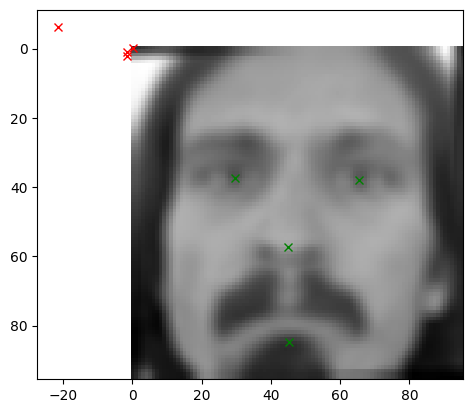

In [27]:
plot_sample = s_trainset[0]
s_model.eval()
with torch.no_grad():
    test_key_points = s_model(plot_sample['image'].unsqueeze(0).to(device)).cpu().numpy()

show_image(image=plot_sample['image'], training_key_points=plot_sample["keypoints"].numpy(), test_key_points=test_key_points)